In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import numpy as np
import matplotlib.pyplot as plt

import time

In [ ]:
# torch.manual_seed(42)

In [77]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device = 'cpu'

print(f'device: {device}')

device: cpu


In [78]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')

        self.layers = layers
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        self.H1 = self.linears[0]

        
    'forward pass'
    def forward(self,x,t):              
        
        # for i in range(len(self.layers)-2):
        #     z = self.linears[i](a)
        #     a = self.activation(z)

        a = torch.cat([x,t], dim = 1)    #(10000,2)

        for i in range(len(self.layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)


            
        b = self.linears[-1](a) 
         
        return b
    
    def forward_direct(self, x,t):
        
        z = torch.cat([x,t], dim = 1)    #(N,2)      N = 1000000

        W1 = self.linears[0].weight    # (50,2)

        H_x = W1[:, 0].unsqueeze(0)      # (1,50)
        F_x = torch.zeros_like(H_x)

        H_t = W1[:, 1].unsqueeze(0)      # (1,50)
        F_t = torch.zeros_like(H_t)
        

        for i in range(len(self.layers)-2):
            L = self.linears[i](z)            # (N,50)
            z = self.activation(L)            # (N,50)
            z_1 = 1.0-torch.square(z)         # (N,50)

            G_x = z_1*H_x     #\sigma'(L)*H   # (N,50)
            G_t = z_1*H_t                     # (N,50)

            C_x = (-2*z + 2*torch.pow(z,3))*H_x*H_x
            C_t = (-2*z + 2*torch.pow(z,3))*H_t*H_t

            E_x = C_x + z_1*F_x    # (N,50)
            E_t = C_t + z_1*F_t    # (N,50)


            H_x = torch.matmul(G_x,self.linears[i+1].weight.t())
            F_x = torch.matmul(E_x,self.linears[i+1].weight.t())

            H_t = torch.matmul(G_t,self.linears[i+1].weight.t())
            F_t = torch.matmul(E_t,self.linears[i+1].weight.t())

        z = self.linears[-1](z)
         
        return z, H_x, H_t, F_x, F_t
    


In [79]:
# layers = np.array([2,50,50,50,50,50,1])
layers = np.array([2,20,20,20,20,20,1])
# PINN = Sequentialmodel(layers).to(device)

In [ ]:
# Resetting to ensure the reported peak truly reflects the training loop, rather than including earlier setup.

# if device.type == 'cuda':
#     torch.cuda.reset_peak_memory_stats(device)

In [115]:
# Create the training data

x = torch.linspace(-1,1,300).view(-1,1)
t = torch.linspace(0,1,300).view(-1,1)


if torch.is_tensor(x) != True:         
    x = torch.from_numpy(x)  
if torch.is_tensor(t) != True:         
    t = torch.from_numpy(t) 

#convert to float
x = x.float()
t = t.float()

    
x_train,t_train = torch.meshgrid(x.squeeze(),t.squeeze(), indexing = 'xy')
# x_train = x_train.reshape(-1,1).to(device)     # 10000 x 1
# t_train = t_train.reshape(-1,1).to(device)    # 10000 x 1

x_train = x_train.reshape(-1,1)     # 10000 x 1
t_train = t_train.reshape(-1,1)   # 10000 x 1





In [116]:
def pde_residual(x, t, nu):
    u = PINN(x,t)

    z, H_x, H_t, F_x, F_t = PINN.forward_direct(x,t)

    du_dx = H_x
    du_dt = H_t
    du_dx_x = F_x

    res_pde = du_dt - (nu / (np.pi)) * du_dx_x + u * du_dx

    return res_pde


    

In [117]:

def initial_condition(x):
  u_ic = PINN(x, torch.zeros_like(x))
  res_ic = u_ic - (-torch.sin(np.pi * x))
  return res_ic

In [118]:
def boundary_condition(t):
    u_left = PINN(torch.full_like(t, -1), t)
    u_right = PINN(torch.full_like(t, 1), t)

    res_left = u_left - torch.zeros_like(t)
    res_right = u_right - torch.zeros_like(t)

    return res_left, res_right

In [119]:
def compute_losses():
   res_pde = pde_residual(x_train, t_train, nu = 0.01) 
   res_ic = initial_condition(x_train)
   res_left, res_right = boundary_condition(t_train)

   loss_pde = torch.mean(res_pde**2)
   loss_ic = torch.mean(res_ic**2)
   loss_bc = torch.mean(res_left**2) + torch.mean(res_right**2)

   total_loss = loss_pde + loss_ic + loss_bc

   return total_loss



In [ ]:
# optimizer = torch.optim.Adam(PINN.parameters(), lr=0.01)

In [ ]:
# # No. of epochs


# start_time = time.time()

# num_epochs = 10000



# for epoch in range(num_epochs):
#     optimizer.zero_grad()

#     total_loss = compute_losses()

    
#     total_loss.backward()

#     optimizer.step()

#     if (epoch) % 200 == 0:
#      print(f'Epoch {epoch}, Loss: {total_loss.item()}')


# end_time = time.time()

# print(f'Total Training Time: {(end_time - start_time): .4f}seconds')


    








Epoch 0, Loss: 0.5874779224395752
Epoch 200, Loss: 0.08226896077394485
Epoch 400, Loss: 0.06502551585435867
Epoch 600, Loss: 0.1309642642736435
Epoch 800, Loss: 0.10850140452384949
Epoch 1000, Loss: 0.06831653416156769
Epoch 1200, Loss: 0.03190504387021065
Epoch 1400, Loss: 0.019339336082339287
Epoch 1600, Loss: 0.006464976817369461
Epoch 1800, Loss: 0.003175830002874136
Epoch 2000, Loss: 0.46274447441101074
Epoch 2200, Loss: 0.0723215863108635
Epoch 2400, Loss: 0.05715584009885788
Epoch 2600, Loss: 0.12301214039325714
Epoch 2800, Loss: 0.2952074706554413
Epoch 3000, Loss: 0.06197576969861984
Epoch 3200, Loss: 0.06029409170150757
Epoch 3400, Loss: 0.04421307519078255
Epoch 3600, Loss: 0.032173041254282
Epoch 3800, Loss: 0.034445397555828094
Epoch 4000, Loss: 0.044414568692445755
Epoch 4200, Loss: 0.06195604428648949
Epoch 4400, Loss: 0.03392459452152252
Epoch 4600, Loss: 0.018131444230675697
Epoch 4800, Loss: 0.03032773546874523
Epoch 5000, Loss: 0.03734999895095825
Epoch 5200, Loss: 0

In [124]:
torch.manual_seed(42)
# PINN = Sequentialmodel(layers).to(device)

PINN = Sequentialmodel(layers)

In [125]:
# if device.type == 'cuda':
#     torch.cuda.reset_peak_memory_stats(device)

In [126]:
optimizer = torch.optim.Adam(PINN.parameters(), lr=0.01)

In [127]:
# Threshold loss as the stopping criteria

max_epochs = 15000
threshold = 0.002



start_time = time.time()

ep = 0
while ep < max_epochs:
    optimizer.zero_grad()

    total_loss = compute_losses()

    
    total_loss.backward()

    optimizer.step()


    if total_loss.item() < threshold:
        print(f"Reached threshold loss {threshold} at epoch {ep}")
        break

    if (ep) % 200 == 0:
     print(f'Epoch {ep}, Loss: {total_loss.item()}')

    ep += 1


print(f"Training stopped at epoch {ep}, total time {time.time() - start_time:.2f} s")





Epoch 0, Loss: 0.5907533168792725
Epoch 200, Loss: 0.0820196121931076
Epoch 400, Loss: 0.04081067815423012
Epoch 600, Loss: 0.053963132202625275
Epoch 800, Loss: 0.01227086316794157
Epoch 1000, Loss: 0.008743063546717167
Epoch 1200, Loss: 0.0038894026074558496
Reached threshold loss 0.002 at epoch 1386
Training stopped at epoch 1386, total time 228.55 s


In [ ]:
# Memory usage after training

# if device.type == 'cuda':
#     peak_mem = torch.cuda.max_memory_allocated(device)
#     print(f'Peak GPU Memory Usage: {peak_mem / 1e6: .2f} MB')

Peak GPU Memory Usage:  6046.05 MB


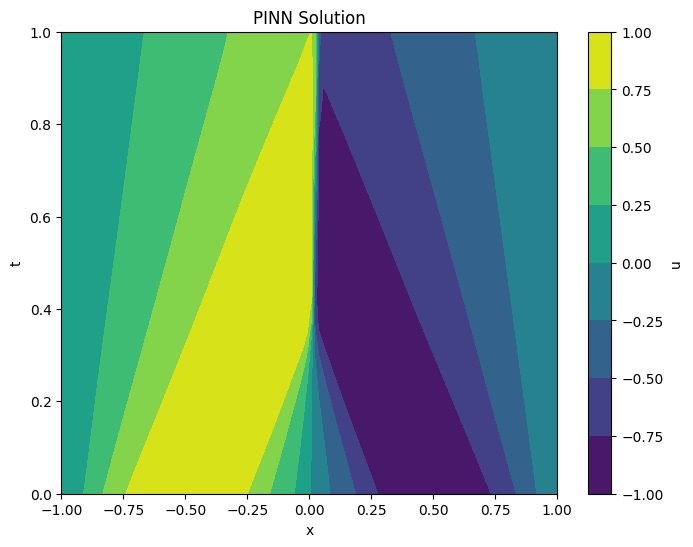

In [35]:
# Evaluate the model

x_test = torch.linspace(-1,1,130, requires_grad = False).to(device).view(-1,1)
t_test = torch.linspace(0,1,130, requires_grad = False).to(device).view(-1,1)
x_test,t_test = torch.meshgrid(x_test.squeeze(),t_test.squeeze(), indexing = 'xy')
x_test = x_test.reshape(-1,1)
t_test = t_test.reshape(-1,1)

PINN.eval()

with torch.no_grad():
  u_test = PINN(x_test, t_test)

# Reshape the predicted u values for contour plotting
x_test = x_test.cpu()
t_test = t_test.cpu()
u_test = u_test.cpu()

x_test = x_test.reshape(130,130)
t_test = t_test.reshape(130,130)
u_test = u_test.reshape(130,130)

# Plot the PINN solution as a contour plot

plt.figure(figsize=(8,6))
plt.contourf(x_test, t_test, u_test, cmap='viridis')
plt.colorbar(label='u')
plt.xlabel('x')
plt.ylabel('t')
plt.title('PINN Solution')
plt.show()